In [264]:
from lib.data import Mimic2
from lib.model import MLP
import numpy as np
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss, wridge, wlasso, lasso, ridge, owl, r4rr
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, reg_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from lib.openbox import open_box, count_config, find_x, open_box_batch, find_all_x

In [282]:
raw_data = []
for fn in glob.glob('models/*dup3*.pkl'):
    name = fn.split('/')[-1].split('.pkl')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])

df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(rec, prec)', 'sparsity'])
print(df.sort_values(['auc'], ascending=False))

      method name   alpha       auc        ap  min(rec, prec)  sparsity
4   wlasso3_dup3*    0.01  0.811123  0.770083        0.442857  0.798683
3     wlasso_dup3    0.01  0.808079  0.503216        0.464286  0.484732
0    wlasso3_dup3   1e-05  0.799297  0.134334        0.417323  0.049636
8    wlasso3_dup3    0.01  0.772758  0.767948        0.423077  0.722388
10   wlasso3_dup3   0.001  0.770541  0.276080        0.336538  0.104095
2     wlasso_dup3   0.001  0.762443  0.192517        0.362319  0.086602
7    wlasso3_dup3  0.0001  0.759586  0.168186        0.362319  0.057913
6     wlasso_dup3  0.0001  0.724533  0.138937        0.340909  0.049716
5     wlasso_dup3   1e-05  0.719948  0.169483        0.289474  0.049005
1    wlasso3_dup3     0.1  0.653593  0.405842        0.326923  0.868229
9     wlasso_dup3     0.1  0.647193  0.339745        0.230469  0.893908


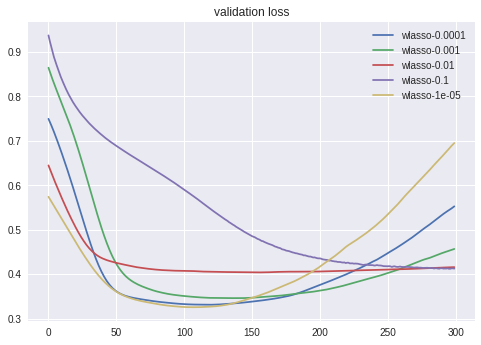

In [175]:
for fn in glob.glob('models2/wlasso^*.valloss.npy'):
    name = fn.split('/')[-1].split('.valloss')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    losses = np.load(fn)
    plt.title("validation loss")
    plt.plot(losses, label="%s-%s" % (name, alpha))
    
plt.legend()
plt.show()

# find out how many classifiers (LLC) are there

In [298]:
m = Mimic2(duplicate=2)
train_data = TensorDataset(*map(lambda x: x.data, prepareData(m.xtrain, m.ytrain)))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


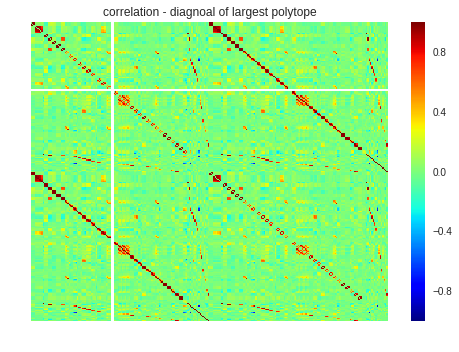

In [303]:
m = Mimic2(duplicate=1, noise=0.1)

corr = np.corrcoef(m.xte.T) # m.xtrain.T
plt.title('correlation - diagnoal of largest polytope')
sns.heatmap(corr - np.diag(np.diag(corr)), cmap='jet')
plt.axis('off')
plt.show()

In [286]:
net = torch.load('models/testwlasso3_dup3^0.01.pt')
config_counter = count_config(net, train_loader)

100%|██████████| 36/36 [00:02<00:00, 14.86it/s]


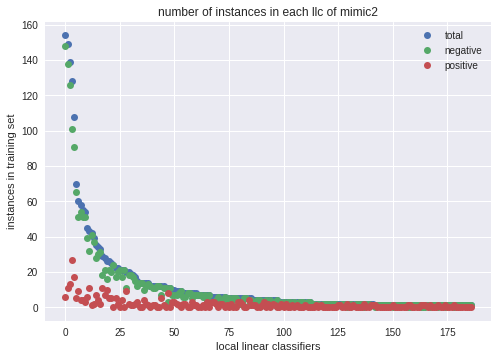

In [287]:
sorted_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), 
                                    config_counter.items()), 
                                key=lambda x: x[1], reverse=True)

plt.plot(list(map(lambda x: x[1], sorted_configs)), 'o', label='total')
plt.plot(list(map(lambda x: x[2], sorted_configs)), 'o', label='negative')
plt.plot(list(map(lambda x: x[3], sorted_configs)), 'o', label='positive')

plt.title('number of instances in each llc of mimic2')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')
plt.legend()
plt.show()

In [288]:
top = 0
x = find_all_x(sorted_configs[top][0], net, train_loader)

In [289]:
len(sorted_configs), len(m.xtrain)

(187, 2250)

/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


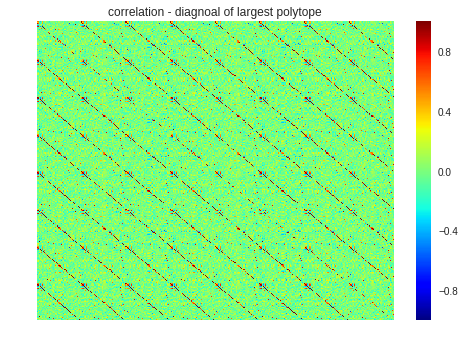

In [290]:
corr = np.corrcoef(x.data.numpy().T) # m.xtrain.T
plt.title('correlation - diagnoal of largest polytope')
sns.heatmap(corr - np.diag(np.diag(corr)), cmap='jet')
plt.axis('off')
plt.show()

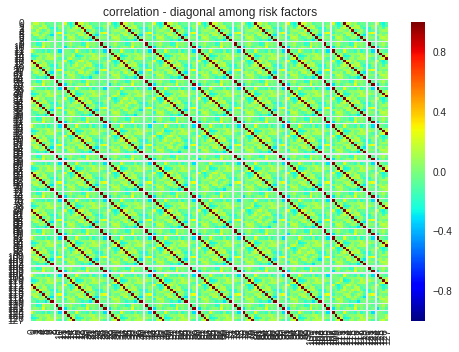

In [291]:
indices = m.r.nonzero().view(-1)
sub_corr = corr[indices][:, indices]
sns.heatmap(sub_corr - np.diag(np.diag(sub_corr)), cmap='jet', vmin=-1, vmax=1)
plt.title('correlation - diagonal among risk factors')
plt.show()

In [292]:
W, b, C = open_box(net, x[0])

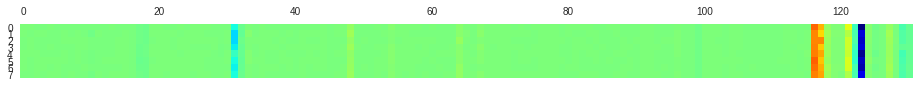

In [295]:
expl = (W[1] - W[0]).data.numpy()
expl_max = np.max(np.abs(expl))
plt.matshow(expl.reshape(8,-1),cmap='jet', vmin=-expl_max, vmax=expl_max)
plt.grid(False)
plt.show()

# How openbox is different from gradient

In [278]:
f = MLP([1, 10, 20, 1], activation=torch.nn.ReLU)

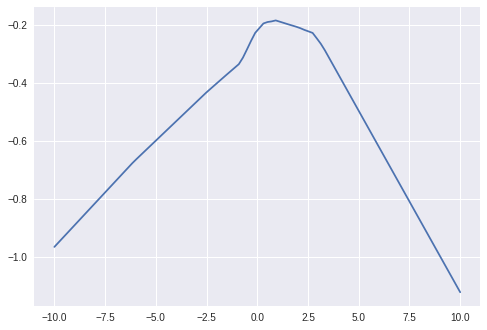

In [279]:
n = 100
x = torch.linspace(-10, 10, n).reshape(n, 1)
plt.plot(x.view(-1).data.numpy(), f(x).view(-1).data.numpy())
plt.show()

In [280]:
samples = torch.FloatTensor([-5, 0, 5]).view(-1,1)
Ws, bs, Cs = open_box_batch(f, samples)